<a href="https://colab.research.google.com/github/timotdsantos/labidub/blob/master/Visualizing_GRID_Corpus_from_Deep_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Table of Contents

Sections and Descriptions

**Install / Import / Load** - import prerequisite libraries

**Getting Sample Images** - pull lip reading repo and test image

**Attribution & UI Code** - visualisation methods

**Produce Neuron Images** - how to save the visualisation to images


# Neuron Groups -- Lip Reading Visualisation

This colab notebook is a modified version of **Building Blocks of Intepretability**  [**read paper here**](https://distill.pub/2018/building-blocks)!

This notebook generates images of the **Neuron Groups**, a technique to visualise how the deep layers recognise segments in the image.

<br>

<img src="https://storage.googleapis.com/lucid-static/building-blocks/notebook_heroes/neuron-groups.jpeg" width="648"></img>

<br>

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!


# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [95]:
!pip install --quiet lucid==0.0.5
!npm install -g svelte-cli@2.2.0

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load, saving,showing
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url, _display_html
from lucid.misc.io.saving import save, save_img
from lucid.misc.io.writing import write_handle

import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map



/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
updated 1 package in 2.808s


# Getting Sample Images

In [0]:
!rm -r labidub

In [89]:
!git clone https://github.com/timotdsantos/labidub

Cloning into 'labidub'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 5), reused 13 (delta 1), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [90]:
!cd labidub/samples
!unzip bbae1a.zip
!cd -

Archive:  bbae1a.zip
   creating: bbae1a/
  inflating: bbae1a/63.jpg           
   creating: __MACOSX/
   creating: __MACOSX/bbae1a/
  inflating: __MACOSX/bbae1a/._63.jpg  
  inflating: bbae1a/62.jpg           
  inflating: __MACOSX/bbae1a/._62.jpg  
  inflating: bbae1a/74.jpg           
  inflating: __MACOSX/bbae1a/._74.jpg  
  inflating: bbae1a/60.jpg           
  inflating: __MACOSX/bbae1a/._60.jpg  
  inflating: bbae1a/48.jpg           
  inflating: __MACOSX/bbae1a/._48.jpg  
  inflating: bbae1a/49.jpg           
  inflating: __MACOSX/bbae1a/._49.jpg  
  inflating: bbae1a/61.jpg           
  inflating: __MACOSX/bbae1a/._61.jpg  
  inflating: bbae1a/75.jpg           
  inflating: __MACOSX/bbae1a/._75.jpg  
  inflating: bbae1a/59.jpg           
  inflating: __MACOSX/bbae1a/._59.jpg  
  inflating: bbae1a/71.jpg           
  inflating: __MACOSX/bbae1a/._71.jpg  
  inflating: bbae1a/65.jpg           
  inflating: __MACOSX/bbae1a/._65.jpg  
  inflating: bbae1a/64.jpg           
  inflati

# Attribution & UI Code

In [0]:
model = models.InceptionV1()
model.load_graphdef()

In [0]:
labels_str = read("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt")
labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [38]:
%%html_define_svelte GroupWidget

<div class="figure" style="width: 600px;">
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <img src="{{img}}">
    {{#if pres_n != undefined}}
    <img src="{{spatial_factors[pres_n]}}" class="overlay"  >
    {{/if}}
  </div>
   
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <div style="width:100%; height: 100%; background-color: #000;"></div>
    {{#each range(n_groups) as n}}
    {{#if pres_n == undefined || pres_n == n}}
    <img src="{{spatial_factors[n]}}" class="factor" 
         style="filter: hue-rotate({{n*360/n_groups}}deg);">
    {{/if}}
    {{/each}}
  </div>
  
  <br>
  <br>
  
  <div on:mouseleave="set({pres_n: undefined})">
    {{#each range(n_groups) as n}}
    <div class="group" style="background-color: hsl({{n*360/n_groups}}, 80%, 50%); "
         on:mouseover="set({pres_n: n})">
      <img src="{{group_icons[n]}}">
    </div>
    {{/each}}
  </div>
  
</div>


<style>
  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .factor {
    mix-blend-mode: lighten;
  }
  .overlay {
    filter: grayscale(100%) brightness(3);
    mix-blend-mode: multiply;
  }
  .group {
    width: 80px;
    height: 80px;
    margin-right: 4px;
    display: inline-block;
    padding-top: 10px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        n_groups: 1,
        spatial_factors: [""],
        group_icons: [""],
        pres_n: undefined,
        
      };
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_V74akK/GroupWidget_2fef9d1.html > /tmp/svelte_V74akK/GroupWidget_2fef9d1.js
svelte version 1.64.1
compiling ../tmp/svelte_V74akK/GroupWidget_2fef9d1.html...
(4:4) – A11y: <img> element should have an alt attribute
(6:4) – A11y: <img> element should have an alt attribute
(14:4) – A11y: <img> element should have an alt attribute
(27:6) – A11y: <img> element should have an alt attribute



In [0]:
def raw_class_group_attr(img, layer, label, group_vecs, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Compute activations
    acts = T(layer).eval()
    
    if label is None: return np.zeros(acts.shape[1:-1])
    
    # Compute gradient
    score = T("softmax2_pre_activation")[0, labels.index(label)]
    t_grad = tf.gradients([score], [T(layer)])[0]   
    grad = t_grad.eval({T(layer) : acts})
    
    # Linear approximation of effect of spatial position
    return [np.sum(group_vec * grad) for group_vec in group_vecs]

In [0]:
def neuron_groups_image(img, layer, n_groups=6, attr_classes=[],display=True):

  # Compute activations

  with tf.Graph().as_default(), tf.Session():
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval()

  # We'll use ChannelReducer (a wrapper around scikit learn's factorization tools)
  # to apply Non-Negative Matrix factorization (NMF).

  nmf = ChannelReducer(n_groups, "NMF")
  spatial_factors = nmf.fit_transform(acts)[0].transpose(2, 0, 1).astype("float32")
  channel_factors = nmf._reducer.components_.astype("float32")

  # Let's organize the channels based on their horizontal position in the image

  x_peak = np.argmax(spatial_factors.max(1), 1)
  ns_sorted = np.argsort(x_peak)
  spatial_factors = spatial_factors[ns_sorted]
  channel_factors = channel_factors[ns_sorted]

  # And create a feature visualziation of each group

  param_f = lambda: param.image(80, batch=n_groups)
  obj = sum(objectives.direction(layer, channel_factors[i], batch=i)
            for i in range(n_groups))
  group_icons = render.render_vis(model, obj, param_f, verbose=False)[-1]
  
  # We'd also like to know about attribution
  
  # First, let's turn each group into a vector over activations
  group_vecs = [spatial_factors[i, ..., None]*channel_factors[i]
                for i in range(n_groups)]
  
  attrs = np.asarray([raw_class_group_attr(img, layer, attr_class, group_vecs)
                     for attr_class in attr_classes])
  
  print attrs
  if display:
    # Let's render the visualization!
    group_url = _image_url(img)
    lucid_svelte.GroupWidget({
      "img" : _image_url(img),
      "n_groups": n_groups,
      "spatial_factors": [_image_url(factor[..., None]/np.percentile(spatial_factors,99)*[1,0,0]) for factor in spatial_factors], 
      "group_icons": [_image_url(icon) for icon in group_icons] 
    })

  return spatial_factors
  

In [0]:
img = load("11.jpg")
# neuron_groups_image(img,'testing',n_groups=16)

# Produce Neuron Images

In [0]:
def neuron_image_write(img_path,out_path,img_output_smoothing="none", \
                       layer="mixed4d",neuron_groups=10,output_size=255, \
                        display=False):
  
  
  img = load(img_path)
  spatial_factors = neuron_groups_image(img, layer, n_groups=neuron_groups,display=display)
  i = 0
  for factor in spatial_factors:
    img_array = factor[..., None]/np.percentile(spatial_factors,99)*[1,0,0]
    if (img_output_smoothing=="smooth"):
      img_array_resized = cv2.resize(test5, dsize=(output_size, output_size), interpolation=cv2.INTER_CUBIC)
    else:
      img_array_resized = cv2.resize(test5, dsize=(output_size, output_size), interpolation=cv2.INTER_AREA)
    save(img_array_resized,'%s_%d.png'%(out_path,i))
    i+=1
  

Run the code silently 

**note:** you must have pulled the test image "11.jpg"

In [85]:
neuron_image_write('11.jpg','testing',neuron_groups=16)

[]


[]



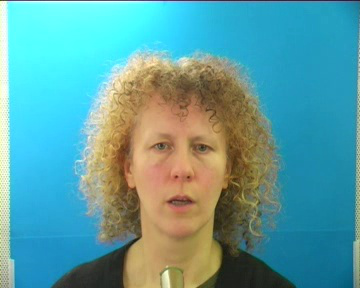
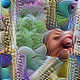
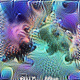
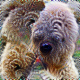
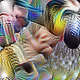
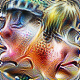
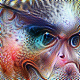
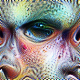
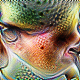
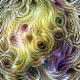
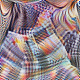

In [67]:
neuron_image_write('11.jpg','testing_no_disp',neuron_group=16,display=True)

# Batch Generate per Speaker

In [0]:
!rm -r bbae1a_out

In [124]:
# n_test=5
# speaker_folder = "bbae1a"
# speaker_output_folder="%s_out"%(speaker_folder)
# file_list = os.listdir(speaker_folder)
# os.mkdir(speaker_output_folder)
# # for i in range(len(file_list)):
# for i in range(n_test):
#   img_filename = file_list[i]
#   img_prefix=img_filename.split(".",1)[0]
#   print(img_prefix)
#   neuron_image_write(speaker_folder+"/"+img_filename,"%s/%s_grp_%d.png"
#                      %(speaker_output_folder,img_prefix,i)
#                      ,neuron_groups=16,display=False)
# archive = speaker_output_folder+".zip"
# !zip -r $archive $speaker_output_folder  

17
[]
05
[]
41
[]
69
[]
61
[]


In [0]:
def extract_speaker_features(speaker_folder="bbae1a"):
  speaker_output_folder="%s_out"%(speaker_folder)
  file_list = os.listdir(speaker_folder)
  os.mkdir(speaker_output_folder)
  # for i in range(len(file_list)):
  for img_filename in file_list:
  #   img_filename = file_list[i]
    img_prefix=img_filename.split(".",1)[0]
    print(img_prefix)
    neuron_image_write(speaker_folder+"/"+img_filename,"%s/%s_grp_%d.png"
                       %(speaker_output_folder,img_prefix,i)
                       ,neuron_groups=16,display=False)
  return speaker_output_folder
# archive = speaker_output_folder+".zip"
# !zip -r $archive $speaker_output_folder  



In [0]:
test_out = extract_speaker_features("bbae1a")
archive = test_out + ".zip"
!zip -r $archive $speaker_output_folder  


17
[]
05
[]
41
[]
69
[]
61
[]
53
[]
06
[]
39
[]
14
[]
25
[]
23
[]
58
[]
45
[]
48
[]
42
[]
33
[]
08
[]
47
[]
03
[]
54
[]
72
[]
49
[]
24
[]
37
[]
36
[]
56
[]
57
[]
60
[]
44
[]
38
[]
71
[]
35
